In [3]:
import torch
from torch.nn import PoissonNLLLoss
n_tasks = 10000
n_train = 40
lr = 0.05
max_steps = 10000
tol = 1e-10
torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"


In [249]:
def sample_data(n_tasks, n_points, d, ws = None, scale=0.32, loss_type="poisson", r=None):
    xs = torch.randn(n_tasks, n_points, d)
    if not isinstance(ws, torch.Tensor):
        ws = scale * torch.randn(n_tasks, d, 1)
    logits = xs @ ws
    mu = torch.exp(logits.clamp(-4, 4))  # shape: [n_tasks, n_points, 1]

    if loss_type == "poisson":
        ys = torch.poisson(mu).squeeze(-1)

    elif loss_type == "nb":
        # r is a scalar or float constant
        r_tensor = torch.tensor(r, dtype=mu.dtype, device=mu.device)
        probs = r_tensor / (r_tensor + mu)
        dist_nb = torch.distributions.NegativeBinomial(total_count=r_tensor, probs=probs)
        ys = dist_nb.sample().squeeze(-1)

    else:
        raise ValueError(f"Unsupported data_type: {loss_type}. Use 'poisson' or 'neg_binomial'.")

    return xs, ys, ws

In [3]:
xs_all, ys_all, ws = sample_data(n_tasks, 40, 10, scale=0.32, loss_type="poisson", r=1)
print(f"xs_all.shape: {xs_all.shape}")
print(f"ys_all.shape: {ys_all.shape}")
print(f"ws.shape: {ws.shape}")

xs_all.shape: torch.Size([10000, 40, 10])
ys_all.shape: torch.Size([10000, 40])
ws.shape: torch.Size([10000, 10, 1])


In [250]:
LOSS_REGISTRY = {}

def register_loss(name):
    def decorator(fn):
        LOSS_REGISTRY[name] = fn
        return fn
    return decorator

@register_loss('poisson')
def poisson_loss(pred, targets, **kwargs):
    return PoissonNLLLoss(log_input=True, full=True, reduction='none')(pred, targets)


@register_loss('nb')
def nb_nll_loss(preds, targets, r):
    mu = torch.exp(preds)  
    r = torch.tensor(r, device=mu.device, dtype=mu.dtype, requires_grad=False)  
    probs = r / (r + mu)
    dist = torch.distributions.NegativeBinomial(total_count=r, probs=probs)
    return -dist.log_prob(targets)




In [ ]:
import torch
from torch.nn import PoissonNLLLoss
from tqdm import tqdm

def run_oracle_on_random_context(context_len, n_tasks, d, lr, max_steps, tol, device="cuda", scale=0.32, r=None, loss_type="poisson", compare_loss=None):
    xs_all, ys_all, ws = sample_data(n_tasks, context_len, d, scale=scale, loss_type=loss_type, r=r)

    # Evaluate only at max context size (i.e., context_len - 1)
    t = context_len - 1
    xs_train = xs_all[:, :t, :].to(device)
    ys_train = ys_all[:, :t].to(device)
    xs_test = xs_all[:, t:t+1, :].to(device)
    ys_test = ys_all[:, t:t+1].to(device)

    loss_fn = LOSS_REGISTRY[loss_type]

    w_hat = torch.randn(n_tasks, d, 1, device=device, requires_grad=True)
    opt = torch.optim.Adam([w_hat], lr=lr)

    prev = float("inf")
    for step in range(1, max_steps + 1):
        logits = (xs_train @ w_hat).squeeze(-1).clamp(min=-4, max=4)
        pred = logits
        loss = loss_fn(pred, ys_train, r=r).mean()
        
        l2_penalty = (0.5 / scale**2) * w_hat.pow(2).sum() / (n_tasks * t) 
        loss += l2_penalty
    
        
        if abs(prev - loss.item()) < tol:
            print(f"[Context {t}] Converged at step {step}")
            break
        prev = loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    else:
        print(f"[Context {t}] DID NOT converge (final Δloss={abs(prev - loss.item()):.2e})")

        
    with torch.no_grad():
        logits_test = (xs_test @ w_hat).squeeze(-1).clamp(min=-4, max=4)
        pred_test = logits_test
        loss = loss_fn(pred_test, ys_test, r=r)
        print(loss_type, loss.mean().item(), loss.std().item())
    
    if compare_loss:
        xs_all, ys_all, _ = sample_data(n_tasks, context_len, d, scale=scale, loss_type=compare_loss, ws=ws, r=r)
        t = context_len - 1
        xs_train = xs_all[:, :t, :].to(device)
        ys_train = ys_all[:, :t].to(device)
        xs_test = xs_all[:, t:t+1, :].to(device)
        ys_test = ys_all[:, t:t+1].to(device)
        
        with torch.no_grad():
            logits_test = (xs_test @ w_hat).squeeze(-1).clamp(min=-4, max=4)
            pred_test = logits_test
            comp_loss = LOSS_REGISTRY[compare_loss](pred_test, ys_test, r=r)
            print(compare_loss, comp_loss.mean().item(), comp_loss.std().item())

    
    
    return loss.mean().item()



# run_oracle_on_random_context(context_len = 10, n_tasks=8000, d=10, lr=0.025, max_steps=10000, 
#                              tol=1e-10, scale=0.32, r = 1.2, device=device, loss_type="nb", compare_loss=None)

loss = 0
context_len = 70
for context in range(5, context_len, 15):
    loss += run_oracle_on_random_context(context_len=context, n_tasks=8000, d=10, lr=0.025, max_steps=10000, 
                                         tol=1e-10, scale=0.2, r = 1.2, device=device, loss_type="nb", compare_loss=None)
# print(loss / (context_len -1 ))

[Context 4] Converged at step 363
poisson 1.5405683517456055 1.6559478044509888
[Context 19] Converged at step 415
poisson 1.3998537063598633 0.9746849536895752
[Context 34] Converged at step 404
poisson 1.367512822151184 0.9016191363334656
[Context 49] Converged at step 404
poisson 1.3410594463348389 0.8240696787834167
[Context 64] Converged at step 388
poisson 1.3448702096939087 0.8238070607185364
[Context 79] Converged at step 389
poisson 1.3310848474502563 0.806324303150177
[Context 94] Converged at step 375
poisson 1.3284610509872437 0.7946507930755615
[Context 109] Converged at step 389
poisson 1.3248337507247925 0.7990977168083191
[Context 124] Converged at step 363
poisson 1.3216010332107544 0.7947897911071777
[Context 139] Converged at step 380
poisson 1.3113781213760376 0.7858120203018188


In [241]:
def oracle_with_true_weights(context_len, n_tasks, d, scale=0.32, r=None, loss_type="poisson", device="cuda"):
    xs_all, ys_all, ws = sample_data(n_tasks, context_len, d, scale=scale, loss_type=loss_type, r=r)

    t = context_len - 1
    xs_test = xs_all[:, t:t+1, :].to(device)
    ys_test = ys_all[:, t:t+1].to(device)
    ws = ws.to(device)

    with torch.no_grad():
        logits = (xs_test @ ws).squeeze(-1).clamp(min=-4, max=4)  # log(mu)
        if loss_type == "poisson":
            pred = logits
            loss_fn = PoissonNLLLoss(log_input=True, full=True, reduction='none')
            loss = loss_fn(pred, ys_test)

        elif loss_type == "nb":
            mu = torch.exp(logits)  # since logits = log(mu)
            r_tensor = torch.tensor(r, device=mu.device, dtype=mu.dtype)
            probs = r_tensor / (r_tensor + mu)
            dist = torch.distributions.NegativeBinomial(total_count=r_tensor, probs=probs)
            loss = -dist.log_prob(ys_test)

        else:
            raise ValueError(f"Unsupported loss_type: {loss_type}")

        print(f"{loss_type} oracle (mean prediction): mean loss = {loss.mean().item():.4f}, std = {loss.std().item():.4f}")
        return loss.mean().item()
context_len = 150
for context in range(5, context_len, 15):
    oracle_with_true_weights(d=10, context_len=context, n_tasks=10000, scale=0.32, r=1.2, loss_type="nb", device=device)

nb oracle (mean prediction): mean loss = 1.7270, std = 1.1886
nb oracle (mean prediction): mean loss = 1.7597, std = 1.2161
nb oracle (mean prediction): mean loss = 1.7453, std = 1.1873
nb oracle (mean prediction): mean loss = 1.7167, std = 1.1784
nb oracle (mean prediction): mean loss = 1.7384, std = 1.2050
nb oracle (mean prediction): mean loss = 1.7186, std = 1.1856
nb oracle (mean prediction): mean loss = 1.7380, std = 1.1912
nb oracle (mean prediction): mean loss = 1.7370, std = 1.2069
nb oracle (mean prediction): mean loss = 1.7317, std = 1.1731
nb oracle (mean prediction): mean loss = 1.7252, std = 1.1804


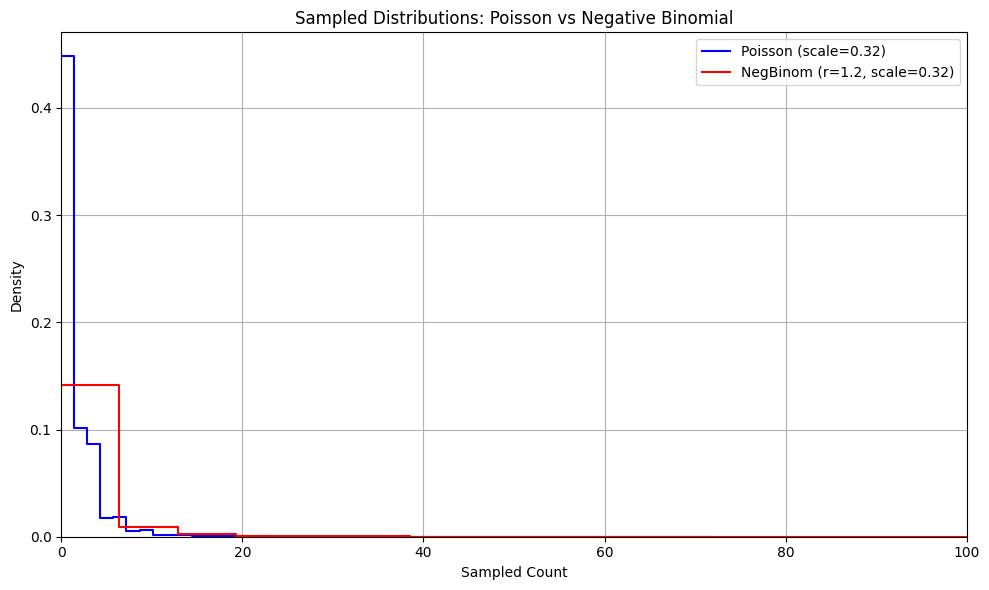

In [247]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def sample_and_plot_distributions(n_samples=1000000, d=10, scale_poisson=2, r_nb=2, scale_nb=2):
    # --- Generate inputs ---
    xs = torch.randn(n_samples, d)  # [n_samples, d]

    # --- Poisson sampling (unique w per sample) ---
    ws_poisson_all = scale_poisson * torch.randn(n_samples, d, 1)  # [n_samples, d, 1]
    xs_unsqueezed = xs.unsqueeze(1)  # [n_samples, 1, d]
    logits_poisson = torch.bmm(xs_unsqueezed, ws_poisson_all).squeeze(-1).squeeze(-1)  # [n_samples]
    mu_poisson = torch.exp(logits_poisson.clamp(-4, 4))  # [n_samples]
    poisson_samples = torch.poisson(mu_poisson).cpu().numpy()

    # --- Negative Binomial sampling (unique w per sample) ---
    ws_nb_all = scale_nb * torch.randn(n_samples, d, 1)  # [n_samples, d, 1]
    logits_nb = torch.bmm(xs_unsqueezed, ws_nb_all).squeeze(-1).squeeze(-1)  # [n_samples]
    mu_nb = torch.exp(logits_nb.clamp(-4, 4))  # [n_samples]
    r_tensor = torch.tensor(r_nb, dtype=mu_nb.dtype, device=mu_nb.device)
    probs = r_tensor / (r_tensor + mu_nb)
    dist_nb = torch.distributions.NegativeBinomial(total_count=r_tensor, probs=probs)
    nb_samples = dist_nb.sample().cpu().numpy()

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    sns.histplot(poisson_samples, bins=50, color='blue', label=f'Poisson (scale={scale_poisson})',
                 stat='density', element='step', fill=False)
    sns.histplot(nb_samples, bins=50, color='red', label=f'NegBinom (r={r_nb}, scale={scale_nb})',
                 stat='density', element='step', fill=False)
    plt.title("Sampled Distributions: Poisson vs Negative Binomial")
    plt.xlabel("Sampled Count")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

# Run with realistic sample size
sample_and_plot_distributions(n_samples=100000, scale_poisson=0.32, scale_nb=0.32, r_nb=1.2)
